# Introduction

EEG was primarily used in humans nearly a century ago. It records the changes in electrical potential near the scalp, which primarily arise from the local synchronous post-synaptic activity of apical dendrites or pyramidal neurons. It is widely used not only in clinical but also in non-clinical situations and is an essential tool in cognitive neuroscience. Statistical analysis of experimental findings indicates that interest in EEG has increased significantly since the early 2000s compared to other recording techniques. Its versatile and portable nature allows its application in various situations (such as sleep, motor tasks, video games, social interactions and such), it does not interfere with other procedures, while accurately recording neuronal activity with millisecond precision, enabling the capture of dynamics related to perception, thought, and behavior. Due to these advantages, the commercial market for EEG systems is larger than that of other recording techniques like PET, MRI, and MEG, which won't be reviewed in this project.

To better evaluate methods for EEG data analysis, it would be ideal to have access to a high-quality EEG recorder, as acquiring such recorder was connected to certain difficulties. This includes the financial costs associated with purchasing and maintaining the equipment, as well as the challenges related to successfully conducting experiments. For this project, we are left with only one option, which is the search for and selection of Open-Source EEG data. But the current challenge is still not straightforward. Many resources found on the internet contain incomplete, unlabeled, or unreliable datasets, making it challenging to find suitable data for our project. The majority of the links were expired. We attempted to establish communication with some of the data providers who had interesting datasets, but we didn't recieve any response.

Finally, we discovered a public repository where we found data that met our criteria. These criteria were simply the availability, validity, and relevance of the data to our area of interest. We also examined what kind of results have been obtained using these data so far.

OpenNeuro is a well-known archive of valuable data created by a team at Stanford University. It is an open platform that allows members to share neurovisualization data with each other. Anyone can access and utilize this data by registering on the website. It has been designated as a repository by the National Institute of Mental Health (NIMH), where neurovisualization data from all Brain Initiative projects are uploaded.

Public EEG Database: 

https://sccn.ucsd.edu/~arno/fam2data/publicly_available_EEG_data.html?fbclid=IwAR27Xiv8qEhm-Q5SpOeb06dbvmcgerQ6jZ2Yej4pZL6qCVBKp8oYRW3JBfY

# Data Explanation

We can obtain data from an existing source that is related to psychophysics. Generally, psychophysics involves studying the relationship between physical stimuli and the intensity of perception or sensation, we will go into details later. Now we are describing the data and challenges regarding its processing:

The data is approximately 700 MB in size and includes recorded signals from 64-channel EEG obtained from 122 subjects. These recordings were performed as part of a visual task conducted by a group of alcoholics and a control group. There is one limitation to this dataset: only epochs (data from 0 to 1 second after stimulus presentation) are available. After decompressing these files, they can be opened and processed using MATLAB. Additionally, we will provide a detailed description of the experiment and explore possible continuations for the project.

The dataset was collected during a large-scale investigation into genetic predisposition to alcoholism. It includes signals obtained from 64 electrodes sampled at a frequency of 256 Hz with a duration of 1 second. Two types of subjects were involved: alcoholic and control group. Each subject was presented with either one type of stimulus (S1) or two types of stimuli (S1 and S2). These stimuli consisted of images from the Snodgrass and Vanderwart's set of pictures from the 1980s. When two stimuli were presented, they were either in a Matched condition, where S1 and S2 stimuli were identical, or in a Non-matched condition, where S1 and S2 stimuli differed.

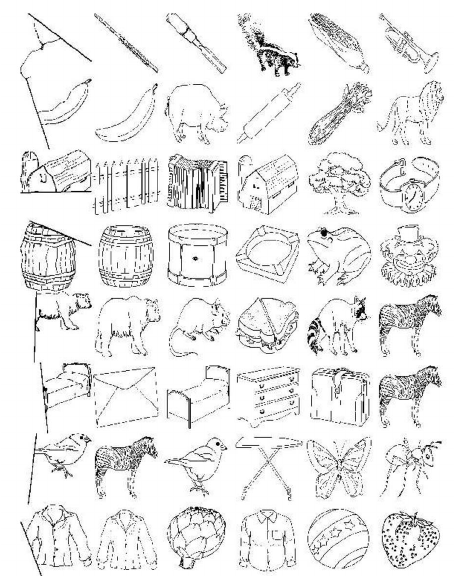

The presented images include example graphs for control and alcoholic subjects. Each graph includes the session, time, electrode number, and the average response of 10 different subjects to the same stimulus.

![](http://kdd.ics.uci.edu/databases/eeg/control.gif)
![](http://kdd.ics.uci.edu/databases/eeg/alcoholic.gif)

There were 122 subjects, each completing 120 tasks with different stimuli presented. The electrode positions were standardized, as in the following image:

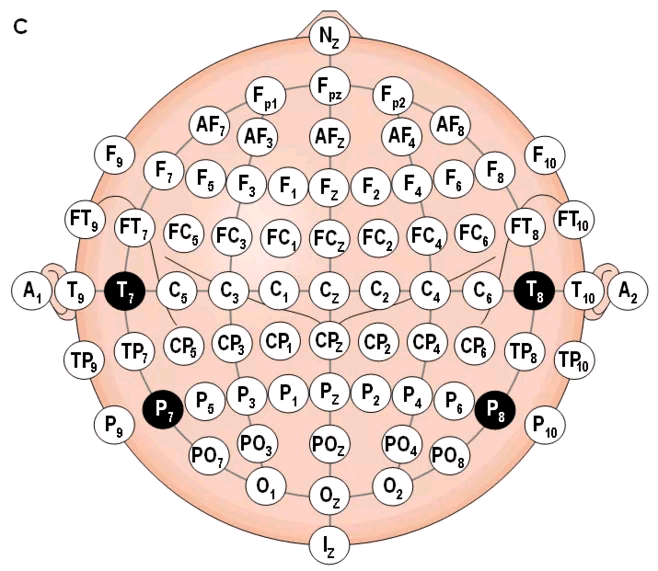

Regarding the data, there are three versions available:

1. Small-sized dataset (smni97_eeg_data.tar.gz) contains data for 2 subjects, an alcoholic (a_co2a0000364) and a control subject (c_co2c0000337). For each of the 3 matching paradigms, there is a corresponding code. "c_1" indicates that only one image was seen by the subject, "c_m" indicates that the second image matched the first one, and "c_n" indicates that the second image did not match the first one. This dataset includes only 10 such tasks.

2. Large-sized dataset (SMNI_CMI_TRAIN.tar.gz and SMNI_CMI_TEST.tar.gz) includes data for 10 alcoholic and 10 control subjects. For each subject and each paradigm, there are 10 tasks, resulting in a total of 100 tasks for each subject.

3. This dataset includes all 120 tasks for all 122 subjects. The total size of the dataset is approximately 700 MB. There are 17 tasks with empty files (co2c1000367). Some tasks have the "err" marker, indicating that they can be excluded from the usable data.

Based on the information obtained so far, we can now proceed to describe our workflow. First and foremost, our motivation is the processing of the data. Following this, our objective will be to explore various methods for classifying EEG data, in this case for alcoholic and control group, but the provided method can be generalized to different types of data. We will discuss the interpretation of the obtained results too.

# Data Extraction

Each trial is stored in a separate file and will be displayed in the following format:

```python
# co2a0000364.rd
# 120 trials, 64 chans, 416 samples 368 post_stim samples
# 3.906000 msecs uV
# S1 obj , trial 0
# FP1 chan 0
0 FP1 0 -8.921
0 FP1 1 -8.433
0 FP1 2 -2.574
0 FP1 3 5.239
0 FP1 4 11.587
0 FP1 5 14.028
...
```

The first four lines of the header contain information. The first line of the header shows the subject identifier, where the fourth character indicates whether the subject is an alcoholic (a) or from the control group (c). The fourth line describes the matching paradigm used: S1 obj (one object is visible), S2 match (object 2 matches object 1), or S2 nonmatch (object 2 does not match object 1). The fifth line represents the sensor identifier, indicating that the data for this sensor starts from the next line. Starting from the sixth line, the text is organized into four columns: trial number, sensor position, sample number (ranging from 0 to 255), and sensor value (in microvolts).

In [1]:
import os
import warnings
import bz2
from io import StringIO
from csv import writer

In [2]:
small_dataset_path = 'smni_eeg_data/'

In [3]:
current_dir = os.listdir(small_dataset_path)

In [4]:
# Write a function which when provided a list of paths and identifiers 
# (alcoholic/non-alcoholic, single/matching/non-matching), 
# returns list of such path strings that comply with these conditions

# paths = String[], alcoholic = Boolean, matching = '1' or 'm' or 'n'
def filter_directory(paths, alcoholic=None, matching=None):
    return list(filter(lambda x: ((alcoholic == True and x[0] == 'a') or (alcoholic != True and x[0] == 'c')) and (matching is None or x[2] == matching), paths))

In [5]:
# Example usage:
filter_directory(current_dir, alcoholic=True, matching='1')

['a_1_co2a0000364']

In [6]:
# Write a function which filters such paths by subject number
def filter_by_subject(paths, number):
    return list(filter(lambda x: x[-3:] == str(number), paths))

In [7]:
# Example usage:
filter_by_subject(current_dir, 337)

['c_n_co2c0000337', 'c_m_co2c0000337', 'c_1_co2c0000337']

After creating these utility functions, we can now proceed with reading each file. For example, let's choose c_1_co2c0000337. On the next line we can see 10 different trials, from which we need to select only one. Let's choose 000 as an example.

In [8]:
os.listdir(os.path.join(small_dataset_path, 'c_1_co2c0000337'))

['co2c0000337.rd.016',
 'co2c0000337.rd.026',
 'co2c0000337.rd.028',
 'co2c0000337.rd.032',
 'co2c0000337.rd.002',
 'co2c0000337.rd.034',
 'co2c0000337.rd.024',
 'co2c0000337.rd.036',
 'co2c0000337.rd.000',
 'co2c0000337.rd.030']

In [9]:
# Open such file and read first 5 lines
file_name = os.path.join(small_dataset_path, 'c_1_co2c0000337', 'co2c0000337.rd.000')
with open(file_name) as src:
    for i in range(5):
        print(src.readline())

# co2c0000337.rd

# 120 trials, 64 chans, 416 samples 368 post_stim samples

# 3.906000 msecs uV

# S1 obj , trial 0

# FP1 chan 0



თითოეულ ფაილში მოცემულია 64-ივე არხის ინფორმაცია. ეს ყველაფერი შეგვიძლია შევკრათ და სამგანზომილებიან მასივში გადავიტანოთ, თუმცა ჯერ კარგი იქნებოდა ეს ინფორმაცია ცხრილის სახით წაგვეკითხა.

In [10]:
import pandas as pd

In [11]:
table = pd.read_csv(file_name, skiprows=5, names=['Trial', 'Sensor', 'Sample', 'Value'], sep=' ', comment='#')
table

Trial Sensor  Sample   Value
0          0    FP1       0   3.082
1          0    FP1       1   2.594
2          0    FP1       2   2.106
3          0    FP1       3   2.106
4          0    FP1       4   3.571
...      ...    ...     ...     ...
16379      0      Y     251  14.476
16380      0      Y     252  15.452
16381      0      Y     253  14.964
16382      0      Y     254  13.987
16383      0      Y     255  12.034

[16384 rows x 4 columns]

In [12]:
# Print unique sensors from the table; save their indices in case we need them
unique_sensors = pd.unique(table['Sensor'])
sensors_dict = dict(zip(unique_sensors, list(range(len(unique_sensors)))))
print(unique_sensors)

['FP1' 'FP2' 'F7' 'F8' 'AF1' 'AF2' 'FZ' 'F4' 'F3' 'FC6' 'FC5' 'FC2' 'FC1'
 'T8' 'T7' 'CZ' 'C3' 'C4' 'CP5' 'CP6' 'CP1' 'CP2' 'P3' 'P4' 'PZ' 'P8' 'P7'
 'PO2' 'PO1' 'O2' 'O1' 'X' 'AF7' 'AF8' 'F5' 'F6' 'FT7' 'FT8' 'FPZ' 'FC4'
 'FC3' 'C6' 'C5' 'F2' 'F1' 'TP8' 'TP7' 'AFZ' 'CP3' 'CP4' 'P5' 'P6' 'C1'
 'C2' 'PO7' 'PO8' 'FCZ' 'POZ' 'OZ' 'P2' 'P1' 'CPZ' 'nd' 'Y']


In [13]:
# Transform whole table into 2D array
trial = []
for sensor in unique_sensors:
    subtable = table[table['Sensor'] == sensor]
    arr = []
    for index, row in subtable.iterrows():
        sample = row['Sample']
        value = row['Value']
        arr.append(value)
    trial.append(arr)

Since the first successful file reading has been completed, we can now choose any signal from a given channel and try to plot its graph to make sure that everything is in order. Let's set time on the x-axis and voltage amplitude on the y-axis.

In [14]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy import interpolate
import pickle
from ipywidgets import IntProgress
from IPython.display import display

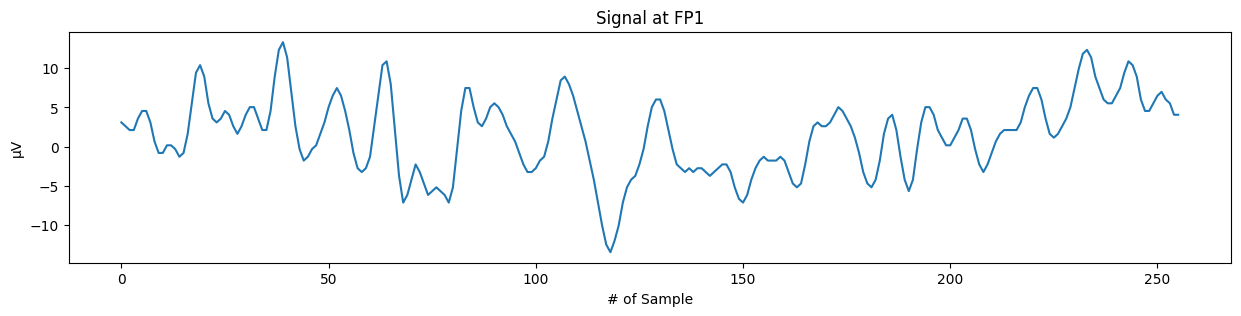

In [15]:
# Plot signal at FP1
plt.figure(figsize=(15, 3))
plt.plot(trial[0])
plt.title("Signal at FP1")
plt.ylabel("µV")
plt.xlabel("# of Sample")
plt.show()

For now everything seems in order. Now let's try plotting everything in three dimensions. Let's add a new axis for the channel index and leave everything else the same.

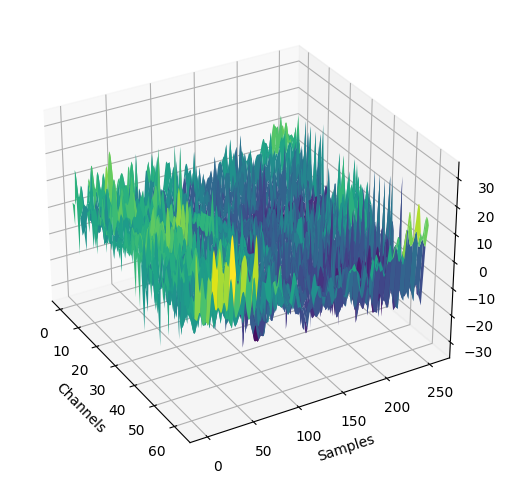

In [16]:
# Create data
x = list(range(len(trial))) # channels
y = list(range(len(trial[0]))) # samples

X, Y = np.meshgrid(x, y)
Z = np.ndarray((X.shape[0], X.shape[1]))
for coord, value in np.ndenumerate(Z):
    Z[coord] = trial[coord[1]][coord[0]]
    
# Create plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Channels')
ax.set_ylabel('Samples')
ax.view_init(30, -30)

ax.plot_surface(X, Y, Z, cmap=cm.viridis, antialiased=True)
plt.show()

The obtained image looks similar to the two images initially displayed. Despite the fact that the examples presented in the first two images seem exaggerated, our assumption for now is that such visual observations can be applied to predict the category. To achieve this, we needed to create some functions which easily generate the graph by providing the file name. Additionally, we require a code that can average multiple signals. Such function for averaging can be defined as follows:

$$ x[n] = \frac{1}{N}\sum_{i=0}^{N - 1}{S_i[n]} $$

Where $x[n]$ represents the n-th sample of the averaged signal, $N$ is the number of subjects, and $S_i$ denotes the signal of the i-th subject. It is also important which signals are averaged. There is no definitive answer to this, we should experiment with different scenarios to determine which approach is more effective.

# Data Visualization

For data visualization, we can consider several types of categorizations:
1. Divide the data into three parts based on the task type: 1, M, or N. Ideally, we should observe variations among different assignment types. The additional reason behind this approach is to observe Event-Related Potentials.
2. Categorize the data into control and alcoholic groups, while keeping the assignment fixed. If we do not fix the assignment, we may introduce a significant amount of variability in the obtained results.

In [17]:
def get_xyz(data):
    # Create data
    x = list(range(len(data))) # channels
    y = list(range(len(data[0]))) # samples

    X, Y = np.meshgrid(x, y)
    Z = np.ndarray((X.shape[0], X.shape[1]))
    for coord, value in np.ndenumerate(Z):
        Z[coord] = data[coord[1]][coord[0]]
        
    return X, Y, Z

In [18]:
def plot_surface(data):
    X, Y, Z = get_xyz(data)

    # Create plot
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('Channels')
    ax.set_ylabel('Samples')
    ax.view_init(30, -30)

    ax.plot_surface(X, Y, Z, cmap=cm.viridis, antialiased=True)
    plt.show()

In [19]:
def read_data(file_path):
    with open(file_path) as src:
        lines = [line for line in src][:5]
        subject_info = {}
        subject_info['type'] = 'Control' if lines[0][5] == 'c' else 'Alcoholic'
        subject_info['id'] = int(lines[0][6:-4].lstrip('0'))
        subject_info['trial'] = int(lines[3].split(' ')[-1])
        subject_info['match'] = '1' if lines[3][3] == '1' else ('M' if lines[3][5] == 'm' else 'N')
              
    table = pd.read_csv(file_path, skiprows=5, names=['Trial', 'Sensor', 'Sample', 'Value'], sep=' ', comment='#')
    
    # Transform whole table into 2D array
    data = np.ndarray((64, 256))
    for row in table.to_numpy():
        sample = row[2]
        value = row[3]
        channel = sensors_dict[row[1]]
        data[channel, sample] = value
        
    return data, subject_info

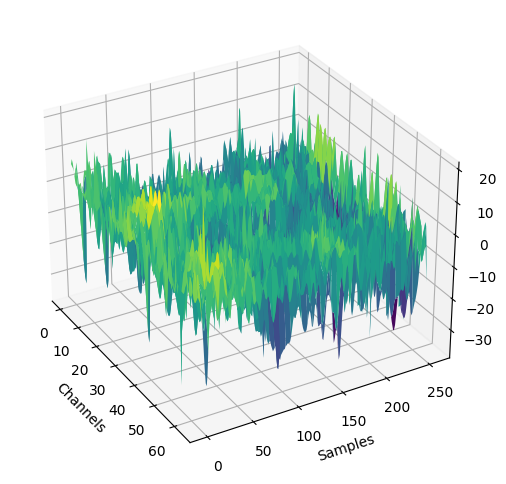

In [20]:
data, info = read_data(os.path.join(small_dataset_path, 'c_m_co2c0000337', 'co2c0000337.rd.027'))
plot_surface(data)

In [21]:
def read_all_files(folder_path):
    all_data = []
    for root, name, files in os.walk(folder_path):
        for file in files:
            path = os.path.join(root, file)
            signal, info = read_data(path)
            all_data.append((signal, info))
    return all_data

In [22]:
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
full_dataset_path = '../full-dataset'
# all_data = read_all_files(full_dataset_path)
# pickle.dump(all_data, bz2.BZ2File('compressed.pickle', 'wb'))

In [23]:
all_data = pickle.load(bz2.BZ2File('compressed.pickle', 'rb'))

In [24]:
list_1 = [i[0] for i in filter(lambda x: x[1]['match'] == '1', all_data)]
list_m = [i[0] for i in filter(lambda x: x[1]['match'] == 'M', all_data)]
list_n = [i[0] for i in filter(lambda x: x[1]['match'] == 'N', all_data)]
list_alc = [i[0] for i in filter(lambda x: x[1]['type'] == 'Alcoholic', all_data)]
list_nonalc = [i[0] for i in filter(lambda x: x[1]['type'] != 'Alcoholic', all_data)]

In [25]:
def average(signals):
    return np.mean(signals, axis=0)

def median(signals):
    return np.median(signals, axis=0)

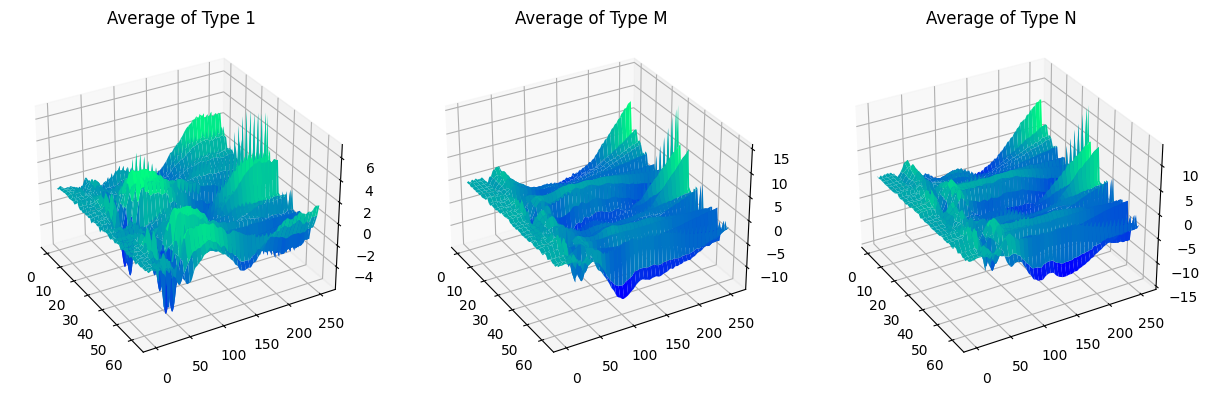

In [26]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(2, 3, 1, projection='3d')
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax3 = fig.add_subplot(2, 3, 3, projection='3d')

# ax4 = fig.add_subplot(2, 3, 4, projection='3d')
# ax5 = fig.add_subplot(2, 3, 5, projection='3d')
# ax6 = fig.add_subplot(2, 3, 6, projection='3d')

X, Y, Z = get_xyz(average(list_1))
ax1.plot_surface(X, Y, Z, cmap=cm.winter, antialiased=True)
ax1.set_title('Average of Type 1')
ax1.view_init(30, -30)

X, Y, Z = get_xyz(average(list_m))
ax2.plot_surface(X, Y, Z, cmap=cm.winter, antialiased=True)
ax2.set_title('Average of Type M')
ax2.view_init(30, -30)

X, Y, Z = get_xyz(average(list_n))
ax3.plot_surface(X, Y, Z, cmap=cm.winter, antialiased=True)
ax3.set_title('Average of Type N')
ax3.view_init(30, -30)

# X, Y, Z = get_xyz(median(list_1))
# ax4.plot_surface(X, Y, Z, cmap=cm.winter, antialiased=True)
# ax4.set_title('Median of Type 1')
# ax4.view_init(30, -30)

# X, Y, Z = get_xyz(median(list_m))
# ax5.plot_surface(X, Y, Z, cmap=cm.winter, antialiased=True)
# ax5.set_title('Median of Type M')
# ax5.view_init(30, -30)

# X, Y, Z = get_xyz(median(list_n))
# ax6.plot_surface(X, Y, Z, cmap=cm.winter, antialiased=True)
# ax6.set_title('Median of Type N')
# ax6.view_init(30, -30)

plt.show()

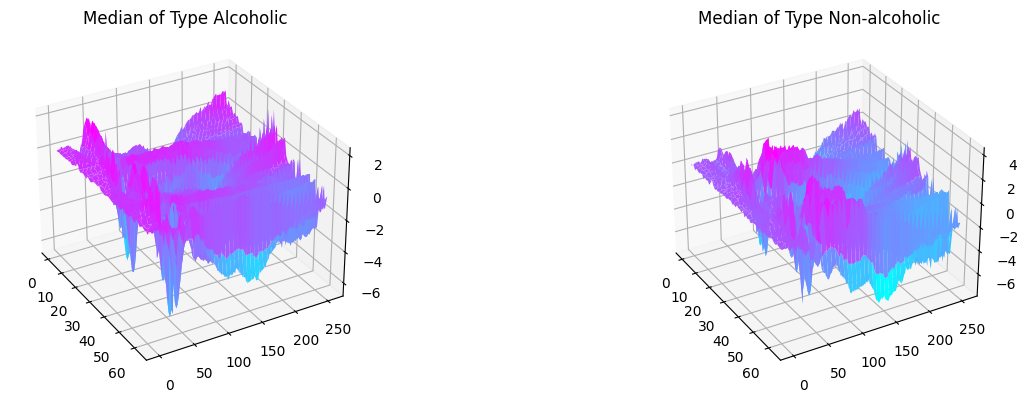

In [27]:
fig = plt.figure(figsize=(15, 10))

# ax1 = fig.add_subplot(2, 2, 1, projection='3d')
# ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax4 = fig.add_subplot(2, 2, 4, projection='3d')

# X, Y, Z = get_xyz(average(list_alc))
# ax1.plot_surface(X, Y, Z, cmap=cm.bone, antialiased=True)
# ax1.set_title('Average of Type Alcoholic')
# ax1.view_init(30, -30)

# X, Y, Z = get_xyz(average(list_nonalc))
# ax2.plot_surface(X, Y, Z, cmap=cm.bone, antialiased=True)
# ax2.set_title('Average of Type Non-alcoholic')
# ax2.view_init(30, -30)

X, Y, Z = get_xyz(median(list_alc))
ax3.plot_surface(X, Y, Z, cmap=cm.cool, antialiased=True)
ax3.set_title('Median of Type Alcoholic')
ax3.view_init(30, -30)

X, Y, Z = get_xyz(median(list_nonalc))
ax4.plot_surface(X, Y, Z, cmap=cm.cool, antialiased=True)
ax4.set_title('Median of Type Non-alcoholic')
ax4.view_init(30, -30)

plt.show()

# Data Transformation

When neurologists attempt to diagnose epilepsy in a patient, they do this by examining signals like this. However, Fourier transformation may be better for analyzing the obtained results, as variation between patients are more apparent. One of the problems with Fourier transformation is that it converts time-domain information entirely in the frequency domain. While we can infer signal frequencies from that, we cannot determine the specific time periods during which these frequency components occur. To address this issue, we will utilize the Discrete Wavelet Transform (DWT) later.

By applying Fourier transformation to a real signal, we obtain a symmetric signal that is mirrored and we can discard half of it. In reality, the maximum frequency band generated by brain, known as the Gamma Band, goes up to  the range of 30 to 50 hertz. Therefore, we can assume frequencies exceeding 50 hertz to be noise.

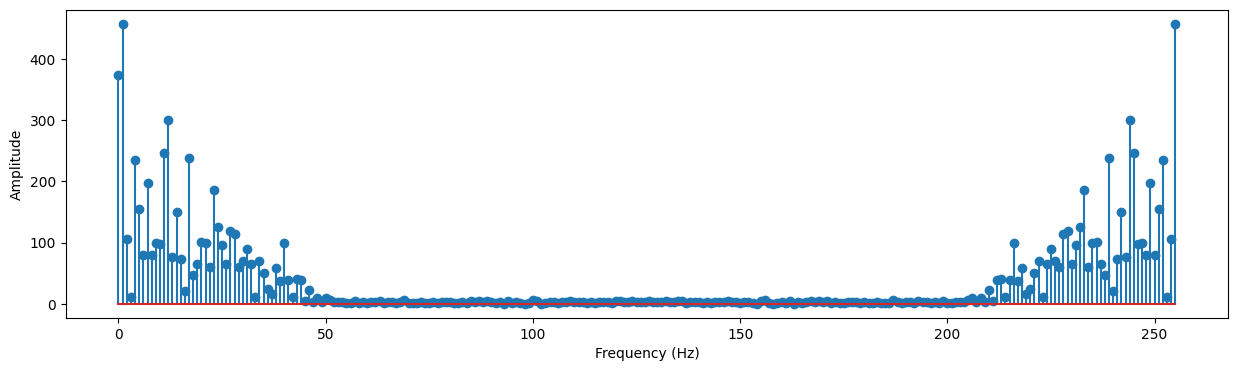

In [28]:
# Plot frequency amplitudes of at FP1
plt.figure(figsize=(15, 4))
plt.stem(range(256), abs(np.fft.fft(trial[0])))
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.show()

If we perform Fourier transformation on signals from all channels, we can analyze the obtained signals and try to find differences between two categories. For example, the frequency range of 25-30 hertz in the average signal of alcoholics may have higher intensity compared to the non-alcoholic in the analogous area.

In [29]:
f_alc = abs(np.fft.fft(median([i[0] for i in filter(lambda x: x[1]['type'] == 'Alcoholic', all_data)])))
f_nonalc = abs(np.fft.fft(median([i[0] for i in filter(lambda x: x[1]['type'] != 'Alcoholic', all_data)])))

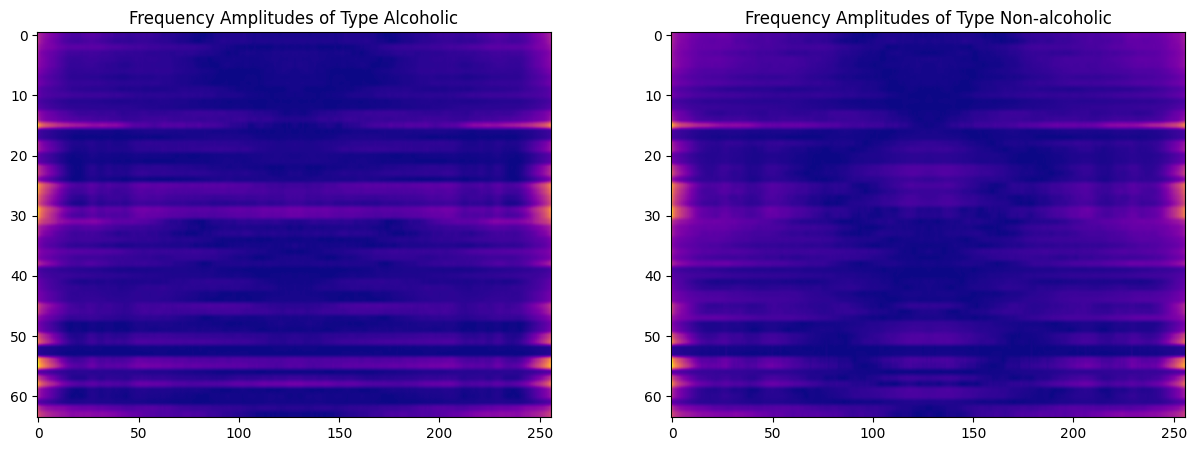

In [30]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

X, Y, Z = get_xyz(abs(np.fft.fft(f_alc)))
ax1.set_title('Frequency Amplitudes of Type Alcoholic')
ax1.imshow(Z.T, cmap=cm.plasma, aspect=3)

X, Y, Z = get_xyz(abs(np.fft.fft(f_nonalc)))
ax2.set_title('Frequency Amplitudes of Type Non-alcoholic')
ax2.imshow(Z.T, cmap=cm.plasma, aspect=3)

plt.show()

Many studies have been conducted in recent years regarding the detection of anomalies, epilepsy, sleep disorders, and BCI systems. Also, in the past few years, research has focused on creating the system which interprets signals coming from the individual and makes decisions or performs instructions based on incoming data.

If we want to create a model or classifier that can be effectively used in practice, such as in BCI, it is crucial to understand the goal of classification, which helps us in selecting the appropriate metrics. Metric selection is a challenging part of the problem, and feature selection is also an ongoing part of the current research. In many cases, different evaluations need to be used to achieve effective classification. The most commonly used techniques are often related to time-frequency transformations, some of which we've already discussed so far.

For example, when analyzing EEG signals of epileptic patients, there is a distinction between pre-seizure and seizure signals, where during seizure gama waves dominate in the frequency spectrum. In other words, during the seizure there are more high frequency components in the EEG signal. In this case it would be wise to classify epileptic and non-epileptic patients by using high frequency amplitudes as a feature. So clearly our approach will vary depending on the classification we aim to achieve.

The method mentioned above may not require the creation of an ML model but there are other classification techniques available. For example, Logistic Regression (LR) is often used because it allows for somewhat straightforward interpretation of the results. It's important to note that before applying any ML model, dimensionality reduction techniques are necessary to reduce the signal's dimensions to avoid overfitting and simplify the interpretation of such results. Artificial Neural Networks (ANN) are also commonly used due to their implementation simplicity and ability to handle large datasets efficiently. Support Vector Machines (SVM) is another classifier that is used broadly in research, where it takes the input of EEG signals divided into five components using DWT. We should consider using some of the mentioned models for the classification of our data, including dimensionality reduction.

For diagnosing the Alzheimer's disease in early stages, researchers used a classifier known as the "Bolzman machine", which classifies the spectrograms of EEG signals (which is essentially an image). We won't delve into the details of this approach, it's just to illustrate that there are many different methods that can be used to classify the data.

Let's return to the current topic. Based on the information gathered so far, we know that analyzing the frequency spectrum of time-domain signal simplifies the analysis process. We have already seen an example of signal transformation. What remains of interest is the application of DWT (Discrete Wavelet Transform) and its use for signal analysis, as well as creating ML models using the features extracted using DWT.

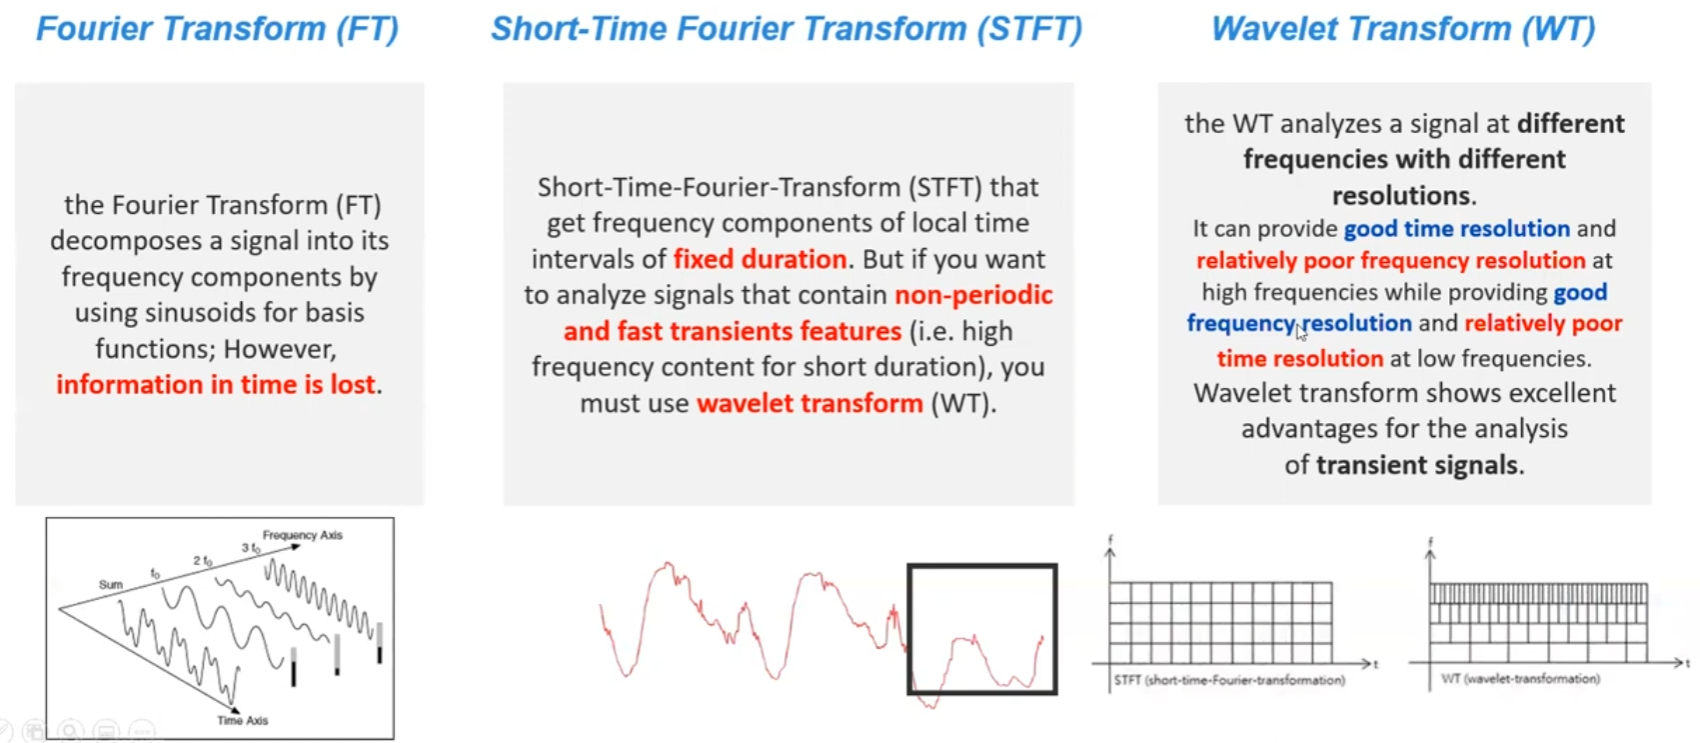

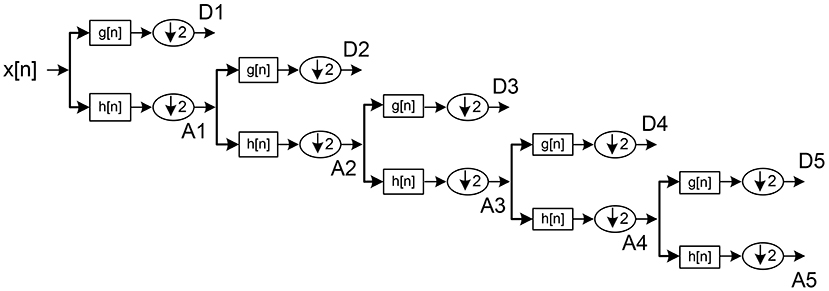

In [37]:
import pywt

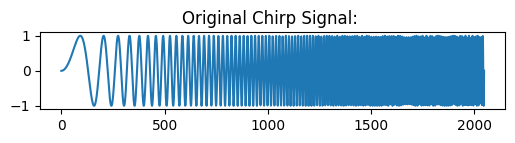

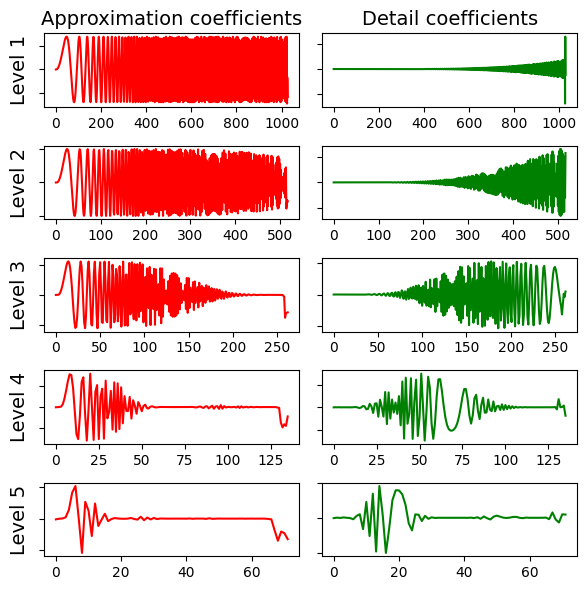

In [38]:
# Heavy coding here
x = np.linspace(0, 1, num=2048)
chirp_signal = np.sin(250 * np.pi * x**2)
    
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Chirp Signal: ")
ax.plot(chirp_signal)
plt.show()
    
data = chirp_signal
detail = []
approx = []
waveletname = 'sym5'
 
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    approx.append(data)
    detail.append(coeff_d)
    
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

If we want better control over the frequency ranges, we can apply Wavelet Packet Transform to the signal, which represents the complete binary tree structure, where frequencies are divided into equal parts. Selecting desired frequency ranges from such representation is easer this way.

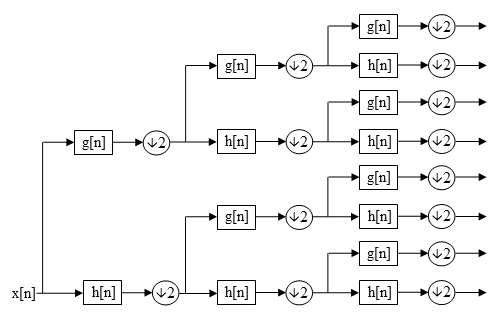

* Delta: <4
* Theta: 4-8
* Alpha: 8-12
* Beta: 13-30
* Gamma: >32

In [39]:
wp = pywt.WaveletPacket(data=chirp_signal, wavelet='db4', mode='symmetric')

In [40]:
# First argument is an WaveletPacket object
# Ranges can be like this: '0-4', '8-12', '12-32', '32-128'
# If verbose is True, calling this function causes it to print the process 
def get_frequency_ranges(wp, *ranges, verbose=False):
    data = wp.data
    leaf_nodes = wp.get_leaf_nodes('freq')
    bandwidth = len(data) // 2 // len(leaf_nodes)
    
    wavelet_packets = {}
    for r in ranges:
        left, right = r.split('-')
        current_band_start = 0
        new_wp = pywt.WaveletPacket(data=None, wavelet=wp.wavelet.name, mode=wp.mode)
        for node in wp.get_level(wp.maxlevel, 'freq'):
            current_band_end = current_band_start + bandwidth
            if (current_band_start >= int(left) and current_band_end <= int(right)):
                if (verbose):
                    print(node.path, r, current_band_start, current_band_end)
                new_wp[node.path] = wp[node.path]
            current_band_start += 4
        wavelet_packets[r] = new_wp
        if (verbose):
            print([n.path for n in new_wp.get_leaf_nodes()])
    return list(wavelet_packets.values())

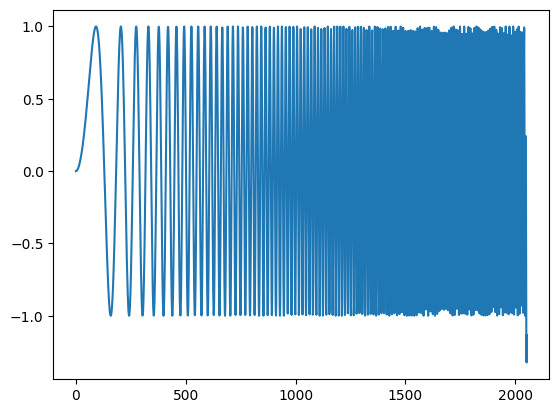

In [41]:
test_range = get_frequency_ranges(wp, '0-1024', verbose=False)
plt.plot(test_range[0].reconstruct(update=False))
plt.show()

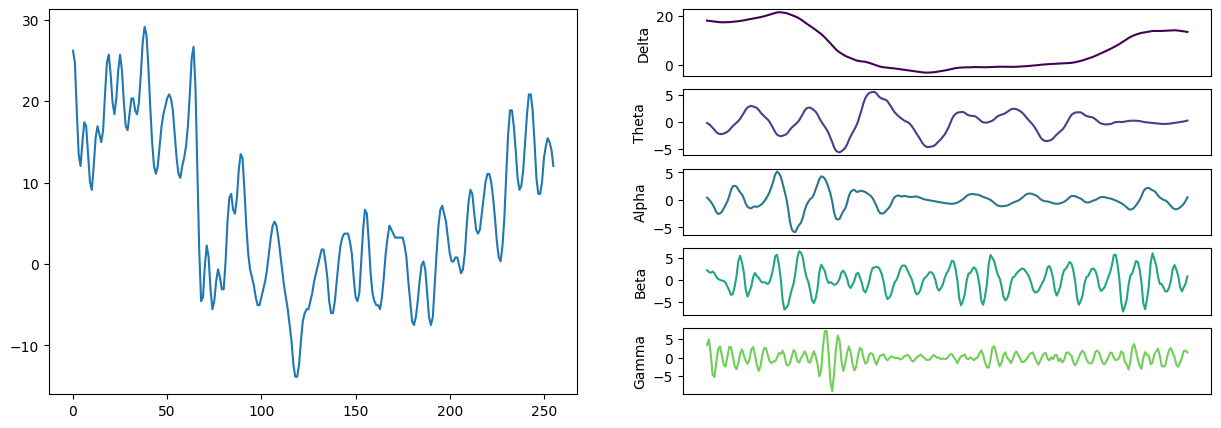

In [42]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)

# Use last channel as an example (any channel would do) 
# Interesting example: 61
test_ch = trial[63]
ax1.plot(test_ch)

# Plot different frequency bands
test_wp = pywt.WaveletPacket(data=test_ch, wavelet='db4', mode='symmetric')
test_franges = get_frequency_ranges(test_wp, '0-4', '4-8', '8-12', '13-30', '32-128', verbose=False)
subplot_index = 2
titles = iter(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])
for frange in test_franges:
    ax = fig.add_subplot(5, 2, subplot_index)
    color = cm.viridis.colors[256 // 10 * (subplot_index - 2)]
    ax.plot(frange.reconstruct(update=False), color=color)
    ax.set_xticks([])
    ax.set_ylabel(next(titles))
    subplot_index += 2
    
plt.show()

This form of data organization helps us better understand the signal's behavior. For example, it may involve the dominant spectral components in beta and gamma frequency bands among alcoholic individuals. However, selecting meaningful values from 64 channels, creating visually interpretable graphs and drawing correct conclusions from that require too much experience for humans, which is impractical. While examining a specific subject, we may benefit from observing signals this way. However, if we have a set of subjects and we want to determine common and distinguishing factors among them, it is better to resort to classification algorithms.

Every classification algorithm requires a set of input parameters. In the analysis of EEG signals, it is a common practice to select certain parameters, such as Relative Sub-band Energy, which calculates the energy of each frequency band (delta, theta, alpha, etc.) separately for each channel and provides a scalar value. There are other examples of input parameters, such as calculating the arithmetic mean for each frequency band.

However, the number of features should not be excessively high. If we were to use the raw signal as a feature, we would have $256\cdot64$ parameters for each signal. When we are calculating 5 values for each channel, indicating the intensity of different frequency sub-bands in the signal, we decrease feature count to $5\cdot64$, which can be quite manageable number. However, this number can be further reduced because not all channels will be equally important, and there will probably exist some features that will have a negligible weight.

Many methods exist to reduce the dimensionality of features, such as PCA, LDA, SVD, among others. However, we will only use PCA in this project. Next we'll focus on calculating the arithmetic mean and the relative sub-band energy of the frequency ranges. Calculating these features requires few steps after calculating DWT of a real signal.

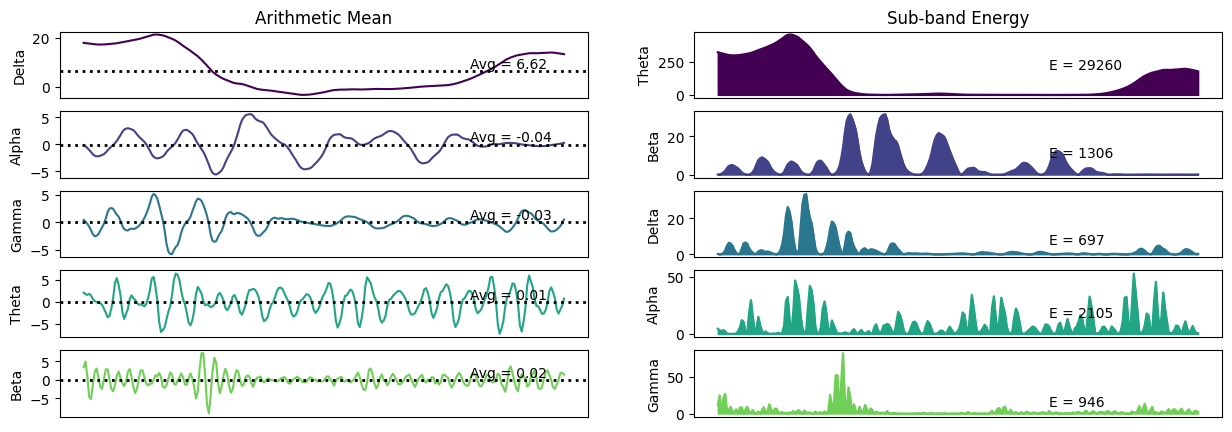

In [43]:
fig = plt.figure(figsize=(15, 5))

# Use last channel as an example (any channel would do) 
# Interesting example: 61
test_ch = trial[63]

# Plot different frequency bands
subplot_index = 1
titles = iter(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'] * 2)
for i in range(len(test_franges) * 2):
    ax = fig.add_subplot(5, 2, subplot_index)
    if (i == 0):
        ax.set_title('Arithmetic Mean')
    if (i == 1):
        ax.set_title('Sub-band Energy')
    
    color = cm.viridis.colors[i // 2 * 50]
    trange = test_franges[i // 2].reconstruct(update=False)
    if (i % 2 == 1):
        trange = trange ** 2
        ax.plot(trange, color=color)
        ax.fill_between(range(len(trange)), trange, color=color)
        ax.text(180, np.average(trange) * 1.5, f'E = {round(sum(trange))}', ha='left', va='bottom')
    else:
        ax.plot(trange, color=color)
        ax.axhline(y=np.average(trange), color='black', linestyle='dotted', linewidth=2)
        ax.text(210, np.average(trange), f'Avg = {round(np.average(trange), 2)}', ha='left', va='bottom')
    ax.set_xticks([])
    ax.set_ylabel(next(titles))
    subplot_index += 1
    
plt.show()

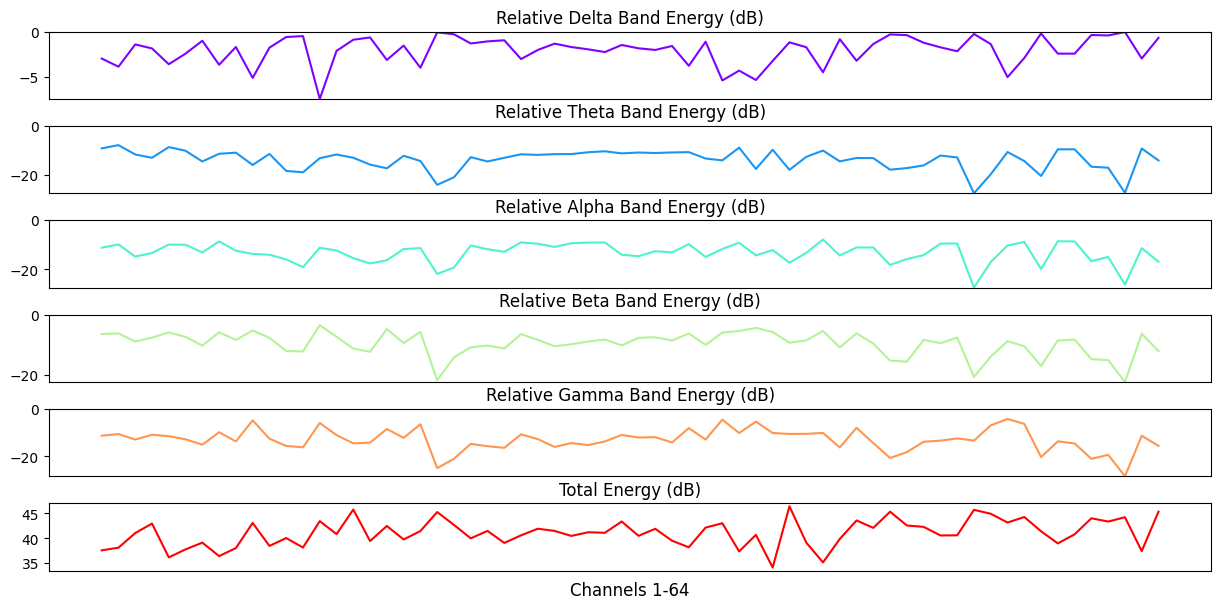

In [44]:
energy_features = np.ndarray((64, 6))
# Iterate channels
for i in range(len(trial)):
    wp = pywt.WaveletPacket(data=trial[i], wavelet='db4', mode='symmetric')
    franges = get_frequency_ranges(wp, '0-4', '4-8', '8-12', '13-30', '32-128', verbose=False)
    # Iterate sub-bands
    subband_energies = []
    for j in range(len(franges)):
        trange = franges[j].reconstruct(update=False)
        subband_energy = sum(trange ** 2)
        subband_energies.append(subband_energy)
    total_energy = sum(subband_energies)
    for j in range(len(subband_energies)):
        relative_energy = subband_energies[j] / total_energy
        energy_features[i, j] = 10 * np.log10(relative_energy)
    energy_features[i, 5] = 10 * np.log10(total_energy)

# Start plotting
fig = plt.figure(figsize=(15, 7))
titles = iter(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])
color = iter(cm.rainbow(np.linspace(0, 1, 6)))
for i in range(6):
    ax = fig.add_subplot(6, 1, i + 1)
    ax.set_xticks([])
    if i < 5:
        ax.set_ylim([min(energy_features[:, i]), 0])
        ax.set_title('Relative ' + next(titles) + ' Band Energy (dB)')
    else:
        ax.set_title("Total Energy (dB)")
        ax.set_xlabel("Channels 1-64", size=12)
    ax.plot(energy_features[:, i], color=next(color))
    
# Set the spacing between subplots, show plot
plt.subplots_adjust(wspace=0, hspace=0.4)
plt.show()

The graph above represents the dominance of different types of frequencies for each channel. These frequencies are represented in decibels (dB). Upon initial observation, it can be seen that the delta frequency has the highest relative energy, which is expected.

These six different graphs provide us with a 64x6 matrix, which can be used as a basis for the classifier's input. Instead of calculating band energy, we could calculate arithmetic means. However, in both cases, the workflow is almost the same, and therefore we only chose the direction to calculate the energies.

Other than drawing graphs, it was necessary to write functions that convert a signal into such a matrix.

In [45]:
# Returns energy features in dB scale and as a percentage representation of total energy (with total energy row omitted)
def get_energy_features(signal):
    p_energy_features = np.ndarray((64, 5))
    db_energy_features = np.ndarray((64, 6))
    for i in range(len(trial)):
        wp = pywt.WaveletPacket(data=trial[i], wavelet='db4', mode='symmetric')
        franges = get_frequency_ranges(wp, '0-4', '4-8', '8-12', '12-32', '32-64', verbose=False)
        subband_energies = []
        for j in range(len(franges)):
            trange = franges[j].reconstruct(update=False)
            subband_energy = sum(trange ** 2)
            subband_energies.append(subband_energy)
        total_energy = sum(subband_energies)
        for j in range(len(subband_energies)):
            relative_energy = subband_energies[j] / total_energy
            p_energy_features[i, j] = relative_energy
            db_energy_features[i, j] = 10 * np.log10(relative_energy)
        db_energy_features[i, 5] = 10 * np.log10(total_energy)
    return p_energy_features, db_energy_features

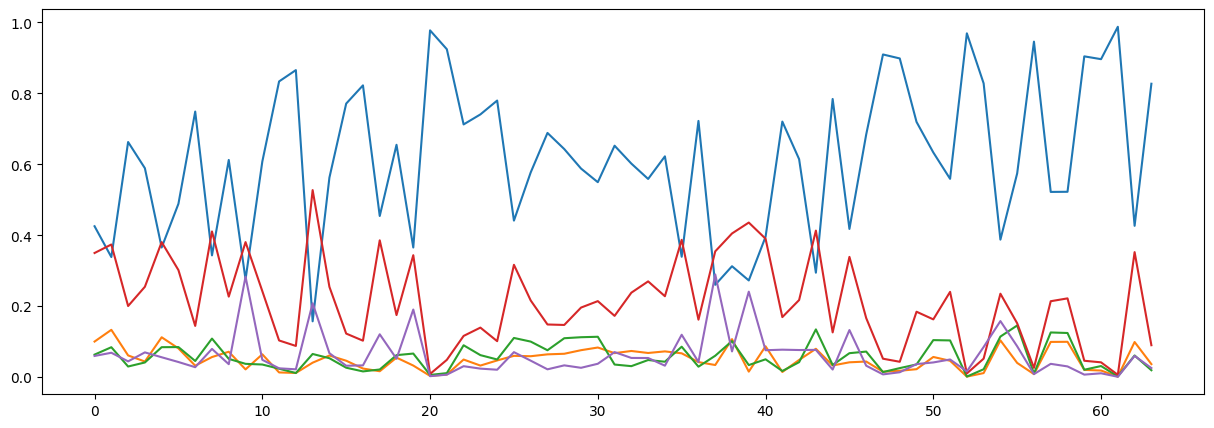

In [46]:
plt.figure(figsize=(15, 5))
p, db = get_energy_features(trial)
for x in p.T:
    plt.plot(x)

In [47]:
def csv_helper(iterable_rows, cols):
    output = StringIO()
    csv_writer = writer(output)

    for row in iterable_rows:
        csv_writer.writerow(row)

    output.seek(0) # we need to get back to the start of the StringIO
    df = pd.read_csv(output, names=cols)
    return df

In [48]:
# %%time
def dump_all_data():
    # Transform whole data to Pandas table
    sufs = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Total']
    cols = ['ID', 'Trial', 'Match', 'Alcoholic'] 

    # Grow cols dynamically
    p_features, db_features = get_energy_features(all_data[0])
    for i, p_feature_row in enumerate(p_features):
        for j, p_feature in enumerate(p_feature_row):
            key = f'{str(i)}CH_P_{sufs[j]}'
            cols.append(key)

    for i, db_feature_row in enumerate(db_features):
        for j, db_feature in enumerate(db_feature_row):
            key = f'{str(i)}CH_DB_{sufs[j]}'
            cols.append(key)

    temp_rows = []

    f = IntProgress(min=0, max=len(all_data)) # Display the bar
    display(f)
    for row in all_data:
        f.value += 1 # Update progress bar

        temp_row = []
        trial = row[0]
        alcoholic = 1 if row[1]['type'] == 'Alcoholic' else 0
        tid = row[1]['id']
        trial_number = row[1]['trial']
        match = 1 if row[1]['match'] == '1' else 2 if row[1]['match'] == 'M' else 3

        p_features, db_features = get_energy_features(trial)
        temp_row.extend([tid, trial_number, match, alcoholic])

        # Each row is a channel, each column is a frequency band
        for p_feature_row in p_features:
            temp_row.extend(p_feature_row)
        for db_feature_row in db_features:
            temp_row.extend(db_feature_row)

        temp_rows.append(temp_row)

    print('Creating DataFrame...')    
    df = csv_helper(temp_rows, cols)

    print('Dumping...')
    pickle.dump(df, bz2.BZ2File('compressed_df.pickle', 'wb'))
    
# dump_all_data()

In [49]:
df = pickle.load(bz2.BZ2File('compressed_df.pickle', 'rb'))
df

ID  Trial  Match  Alcoholic  0CH_P_Delta  0CH_P_Theta  0CH_P_Alpha  \
0      364      0      1          1     0.629541     0.067086     0.020202   
1      364      2      1          1     0.815429     0.156929     0.020691   
2      364      7      3          1     0.909863     0.066265     0.003977   
3      364      9      2          1     0.908360     0.025999     0.005103   
4      364     10      1          1     0.913514     0.052261     0.027564   
...    ...    ...    ...        ...          ...          ...          ...   
10889  402    115      3          0     0.823712     0.033206     0.059109   
10890  402    116      1          0     0.949333     0.002269     0.014018   
10891  402    117      2          0     0.499184     0.266880     0.026672   
10892  402    118      1          0     0.671849     0.208985     0.034798   
10893  402    119      2          0     0.951226     0.032714     0.007578   

       0CH_P_Beta  0CH_P_Gamma  1CH_P_Delta  ...  62CH_DB_Alpha  62CH_DB_Beta  \
0        0.164646     0.118525     0.462961  ...     -17.194011     -8.058764   
1        0.005768     0.001184     0.763740  ...     -16.966237    -22.443983   
2        0.012452     0.007442     0.886264  ...     -24.364767    -18.892426   
3        0.033593     0.026945     0.767451  ...     -22.814842    -14.360890   
4        0.004856     0.001805     0.910992  ...     -15.597121    -23.139160   
...           ...          ...          ...  ...            ...           ...   
10889    0.067907     0.016066     0.854717  ...      -9.933966    -12.046787   
10890    0.028671     0.005709     0.932593  ...     -19.458693    -17.263075   
10891    0.167204     0.040059     0.543283  ...     -20.804935    -14.019023   
10892    0.065023     0.019346     0.632042  ...     -13.394082    -12.721336   
10893    0.006809     0.001673     0.947683  ...     -23.190027    -24.300994   

       62CH_DB_Gamma  62CH_DB_Total  63CH_DB_Delta  63CH_DB_Theta  \
0          -9.345049      42.182295      -1.219656     -15.680864   
1         -29.273579      57.595741      -1.597777     -11.426513   
2         -21.107696      51.274913      -1.681386     -11.669320   
3         -15.128539      45.931387      -0.216923     -20.358701   
4         -27.317378      55.407501      -2.167534     -13.880331   
...              ...            ...            ...            ...   
10889     -18.559366      41.970305      -1.516284      -9.310463   
10890     -24.535470      47.206571      -0.245887     -16.757044   
10891     -20.912440      42.660696      -0.490907     -12.982692   
10892     -17.171693      42.122426      -1.620341      -7.136013   
10893     -29.432420      51.932642      -0.138048     -16.659126   

       63CH_DB_Alpha  63CH_DB_Beta  63CH_DB_Gamma  63CH_DB_Total  
0         -22.664558     -9.518064      -9.971285      45.597354  
1         -17.227523     -8.290507     -11.634013      44.092624  
2         -18.478588     -9.276904      -9.186020      42.991830  
3         -23.798773    -16.626565     -18.664570      49.916413  
4         -12.818339     -6.954466     -10.082983      41.038377  
...              ...           ...            ...            ...  
10889      -9.981853    -12.052733     -18.313912      41.952501  
10890     -19.328983    -17.307545     -24.335977      47.173798  
10891     -20.678611    -14.040952     -20.669315      42.684389  
10892     -13.398905    -12.727521     -17.225458      42.089125  
10893     -23.137935    -24.266669     -29.563145      51.856392  

[10894 rows x 708 columns]

In [55]:
import seaborn as sns
from scipy import stats

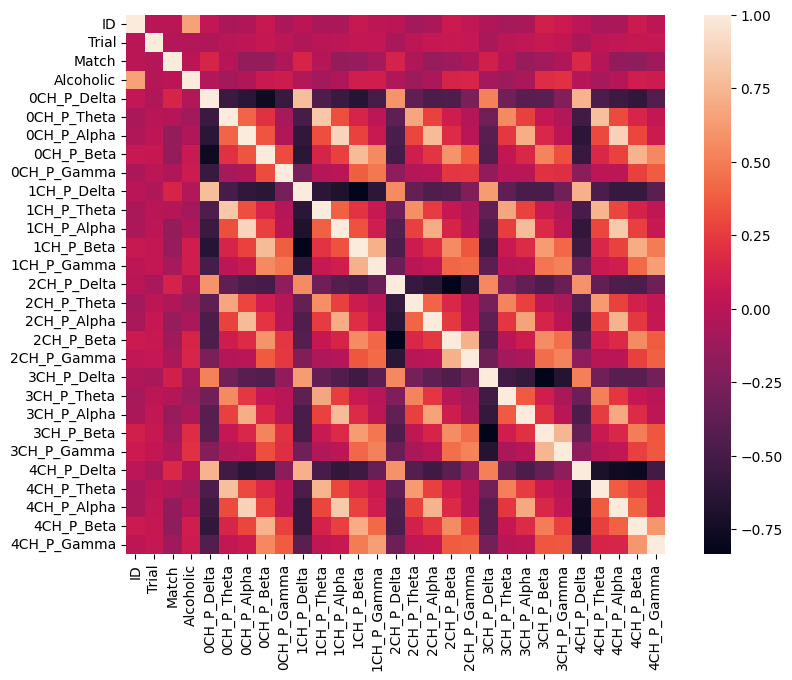

In [56]:
# Plot correlation matrix
corrmat = df.iloc[:, :29].corr()
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corrmat, square=True);

This image shows the correlation of delta coefficients on the correlation matrix. Since delta energy always dominates the signal, it has a negative correlation with the coefficients of other spectra. Each small square represents the crossover of different channels, and the more light a square is, it means those two channels tend to activate together. By observing this pattern, we can see that neighboring channels are positively correlated, which is logical since the activation of one area of the brain often extends to its neighboring areas.

What we need next is a reduction in the number of features. In the current dataset, we have 708 columns, but the majority of the data is duplicated in different records (percentage and delta values). We can remove the percentage values as a whole since they contain the same information as in the dB values. The total energy columns should remain unchanged.

In [57]:
filtered_col_names = list(filter(lambda x: '_P_' not in x, list(df.columns)))
df = df.loc[:, df.columns.isin(filtered_col_names)]
df

ID  Trial  Match  Alcoholic  0CH_DB_Delta  0CH_DB_Theta  0CH_DB_Alpha  \
0      364      0      1          1     -2.009757    -11.733696    -16.946053   
1      364      2      1          1     -0.886139     -8.042965    -16.842276   
2      364      7      3          1     -0.410239    -11.787149    -24.004446   
3      364      9      2          1     -0.417421    -15.850414    -22.921747   
4      364     10      1          1     -0.392849    -12.818183    -15.596576   
...    ...    ...    ...        ...           ...           ...           ...   
10889  402    115      3          0     -0.842248    -14.787836    -12.283476   
10890  402    116      1          0     -0.225816    -26.441024    -18.533120   
10891  402    117      2          0     -3.017390     -5.736833    -15.739408   
10892  402    118      1          0     -1.727286     -6.798858    -14.584493   
10893  402    119      2          0     -0.217162    -14.852678    -21.204321   

       0CH_DB_Beta  0CH_DB_Gamma  0CH_DB_Total  ...  62CH_DB_Alpha  \
0        -7.834500     -9.261890     42.024802  ...     -17.194011   
1       -22.390043    -29.267459     57.712726  ...     -16.966237   
2       -19.047440    -21.282963     51.447309  ...     -24.364767   
3       -14.737531    -15.695181     46.421029  ...     -22.814842   
4       -23.137341    -27.435626     55.579757  ...     -15.597121   
...            ...           ...           ...  ...            ...   
10889   -11.680851    -17.940804     39.889342  ...      -9.933966   
10890   -15.425537    -22.434588     42.720985  ...     -19.458693   
10891    -7.767529    -13.973015     34.711418  ...     -20.804935   
10892   -11.869329    -17.134062     40.782470  ...     -13.394082   
10893   -21.669086    -27.766185     50.437847  ...     -23.190027   

       62CH_DB_Beta  62CH_DB_Gamma  62CH_DB_Total  63CH_DB_Delta  \
0         -8.058764      -9.345049      42.182295      -1.219656   
1        -22.443983     -29.273579      57.595741      -1.597777   
2        -18.892426     -21.107696      51.274913      -1.681386   
3        -14.360890     -15.128539      45.931387      -0.216923   
4        -23.139160     -27.317378      55.407501      -2.167534   
...             ...            ...            ...            ...   
10889    -12.046787     -18.559366      41.970305      -1.516284   
10890    -17.263075     -24.535470      47.206571      -0.245887   
10891    -14.019023     -20.912440      42.660696      -0.490907   
10892    -12.721336     -17.171693      42.122426      -1.620341   
10893    -24.300994     -29.432420      51.932642      -0.138048   

       63CH_DB_Theta  63CH_DB_Alpha  63CH_DB_Beta  63CH_DB_Gamma  \
0         -15.680864     -22.664558     -9.518064      -9.971285   
1         -11.426513     -17.227523     -8.290507     -11.634013   
2         -11.669320     -18.478588     -9.276904      -9.186020   
3         -20.358701     -23.798773    -16.626565     -18.664570   
4         -13.880331     -12.818339     -6.954466     -10.082983   
...              ...            ...           ...            ...   
10889      -9.310463      -9.981853    -12.052733     -18.313912   
10890     -16.757044     -19.328983    -17.307545     -24.335977   
10891     -12.982692     -20.678611    -14.040952     -20.669315   
10892      -7.136013     -13.398905    -12.727521     -17.225458   
10893     -16.659126     -23.137935    -24.266669     -29.563145   

       63CH_DB_Total  
0          45.597354  
1          44.092624  
2          42.991830  
3          49.916413  
4          41.038377  
...              ...  
10889      41.952501  
10890      47.173798  
10891      42.684389  
10892      42.089125  
10893      51.856392  

[10894 rows x 388 columns]

Upon inspecting the table, it becomes evident that some values are undefined. This inconsistency will complicate the process of transforming data, so it is necessary to either replace such values or completely remove the rows containing undefined values.

In [58]:
df.isnull().sum()

ID                0
Trial             0
Match             0
Alcoholic         0
0CH_DB_Delta     26
                 ..
63CH_DB_Theta    20
63CH_DB_Alpha    20
63CH_DB_Beta     20
63CH_DB_Gamma    20
63CH_DB_Total     0
Length: 388, dtype: int64

In our case, we will remove such rows because their count is negligible (1-2%).

In [59]:
df = df.dropna()

Now, if we examine the distribution of values for a particular feature, we will observe that some of them exhibit a normal distribution. However, for certain values (particularly the coefficients of the delta spectrum), are skewed to the right.

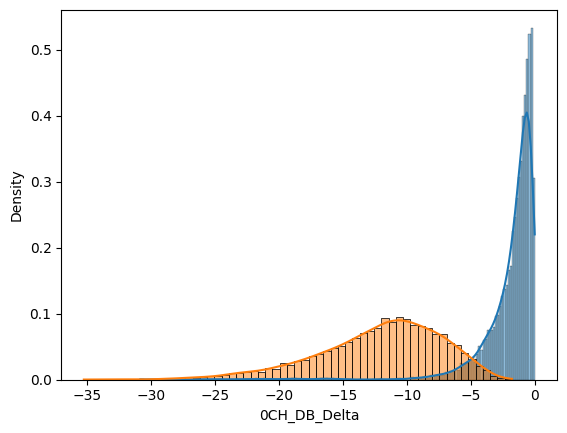

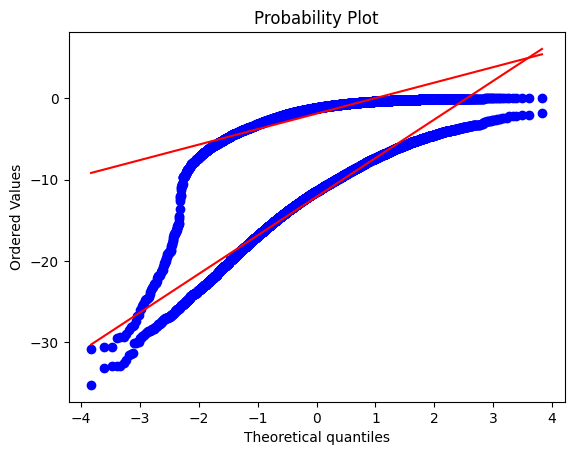

In [60]:
sns.histplot(df['0CH_DB_Delta'], kde=True, stat="density")
sns.histplot(df['0CH_DB_Beta'], kde=True, stat="density")
fig = plt.figure()
res = stats.probplot(df['0CH_DB_Delta'], plot=plt)
res = stats.probplot(df['0CH_DB_Beta'], plot=plt)

Generally, many classification algorithms require features to be standartized, meaning they should have a distribution with a mean of 0 and a standard deviation of 1. It is also common for input data to be normalized, typically ranging from 0 to 1. We will ensure that both our variables undergo these transformations before applying any classification algorithm. For this purpose, we will use the sklearn library. Additionally, we need to remove the first two columns from the current table since they do not serve as features.

We will use the StandardScaler function from sklearn for standardizing the distribution. Note that we should not standardize categorical columns (Match and Alcoholic) since they are not continuous variables.

In [66]:
from sklearn.preprocessing import StandardScaler

# Drop 2 columns
train = df.iloc[:, 2:]
train_stand = train.copy()

# Apply standardization on numerical features
num_cols = list(train_stand.columns)[2:]
for i in num_cols:
    # Fit on training data column
    scale = StandardScaler().fit(train_stand[[i]])
    
    # Transform the training data column
    train[i] = scale.transform(train_stand[[i]])

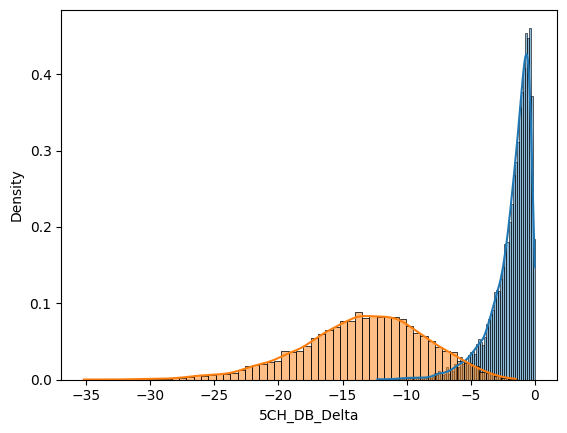

In [67]:
fig = plt.figure()
sns.histplot(train_stand['5CH_DB_Delta'], kde=True, stat="density")
sns.histplot(train_stand['5CH_DB_Alpha'], kde=True, stat="density")
plt.show()

The standardization of most distributions has been successful. However, as observed below, the transformation of the delta spectrum features did not help the distribution. The next step is to create a copy of the existing table and normalize/scale all the variables within it. There are two different options for the table: one is to perform standardization on the variables, which is suitable for some algorithms like SVM, while another option is normalization, which provides better results for algorithms like KNN. Decision Trees, on the other hand, do not require variable distribution adjustments. Therefore, we will save both versions and analyze which one provides the best outcome.

In [68]:
from sklearn.preprocessing import MinMaxScaler

train_norm = train.copy()

# Fit scaler on training data
norm = MinMaxScaler().fit_transform(train_norm)
train_norm[train_norm.columns] = norm

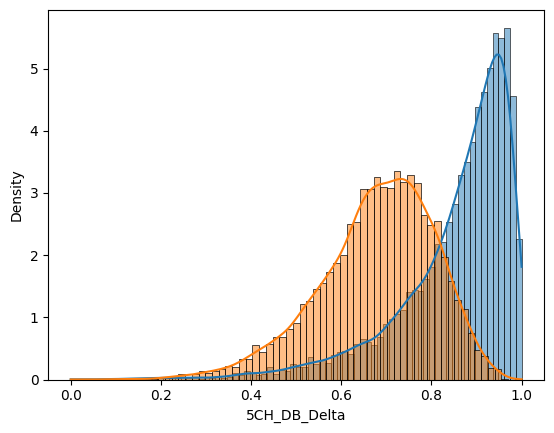

In [69]:
fig = plt.figure()
sns.histplot(train_norm['5CH_DB_Delta'], kde=True, stat="density")
sns.histplot(train_norm['5CH_DB_Beta'], kde=True, stat="density")
plt.show()

In [71]:
# At this point we have train and train_norm tables.

# Data Classification

მანქანური სწავლების მოდელებზე ექსპერიმენტაციის დროს დავაკვირდებით თუ რა კონფიგურაციები შეცვლის მოდელის პერფორმანსის მეტრიკას უკეთესობისკენ და ამის მიხედვით შევცვლით შემავალ პარამეტრებს.

პერფორმანსის ეს მეტრიკები კომპაქტურად ჩაიწერება ე.წ. Confusion Matrix-ში, რომლის თითოეულ მეოთხედში წერია მოდელის მიერ ნაწინასწარმეტყველები შედეგების სიზუსტის რაოდენობა. თითოეული მეოთხედი შედგება:

• True Negatives: რომლების კლასიც 0 იყო და მოდელმაც 0-ად დააკლასიფიცირა.

• False Positives: რომლების კლასიც 0 იყო მაგრამ მოდელმა 1-ად დააკლასიფიცირა.

• False Negatives: რომლების კლასიც 1 იყო და მოდელმა 0-ად დააკლასიფიცირა.

• True Positives: რომლების კლასიც 1 იყო და მოდელმაც 1-ად დააკლასიფიცირა.

თითოეული Confusion Matix-ისთვის ითვლება მომდევნო 3 მეტრიკა:

**Accuracy:** მოდელის წინასწარმეტყველების რა წილი იყო ჭეშმარიტი

$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

**Precision:** დადებითად კლასიფიცირებულ შედეგებში ჭეშმარიტად დადებითის წილი

$Precision = \frac{TP}{TP + FP}$

**Recall:** სწორად კლასიფიცირებული პოზიტიური წინასწარმეტყველების წილი

$Recall = \frac{TP}{TP + FN}$

## Logistic Regression

პირველ კლასიფიკაციის მეთოდად შევარჩიეთ ლოგისტიკური რეგრესია, რომელიც შედეგად გვიბრუნებს რიცხვს 0-სა და 1-ს შორის, რომელიც ალბათობას აღნიშნავს თუ რომელ კატეგორიაში კლასიფიცირდება შევამალი მონაცემი. ლოგისტიკურ რეგრესიაში გამოყენებული ფუნქცია სიგმოიდია, რომელიც ასე განიმარტება:

$$ f(z)=\cfrac{1}{1+e^{-z}} $$

სადაც $z = \beta_0 + \beta_1x_1 + \beta_2x_2 + \dots + \beta_nx_n$. ბეტა კოეფიციენტები აღნიშნავენ კლასიფიკატორის წონებს, ხოლო $x_n$ აღნიშნავს მონაცემის მე-n ცვლადს.

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score

In [56]:
X = train_norm.loc[:, train_norm.columns != 'Alcoholic'].to_numpy()
Y = train_norm['Alcoholic'].to_numpy()

In [57]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [58]:
model = LogisticRegression(solver='liblinear', penalty='l2', C=40, random_state=42).fit(x_train, y_train)
model.score(x_test, y_test)

0.8659217877094972

ჩვენი შექმნილი მოდელის სიზუსტე 86%-ს აღწევს. დავწეროთ ფუნქცია, რომელიც Confusion Matrix-ს დაგვიხატავს და Recall/Precision/Accuracy კოეფიციენტებს დაგვითვლის, რაც შედეგების უკეთ ინტერპრეტირების საშუალებას მოგვცემს.

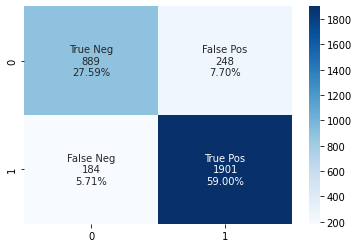

Accuracy: 0.8659217877094971
Precision: 0.8845974872033503
Recall: 0.9117505995203836


In [59]:
cm = confusion_matrix(y_test, model.predict(x_test))

def plot_cm(cm):
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.show()
    
    tn, fp, fn, tp = [value for value in cm.flatten() / np.sum(cm)]
    print(f'Accuracy: {(tp + tn) / (tp + fn + fp + tn)}')
    print(f'Precision: {tp / (tp + fp)}')
    print(f'Recall: {tp / (tp + fn)}')    

plot_cm(cm)

ყველაფერთან ერთად დავითვლით AUC ქულას. ეს რიცხვი არის შანსი, რომ ორ განსხვავებულ ადამიანს შორის სწორად გავარჩიოთ ვინ რომელ კატეგორიას მიეკუთვნება. ამ მეტრიკას მხოლოდ იმ კლასიფიკატორებისთვის გამოვიყენებთ, რომლებიც Output-ად ალბათობებს გვიბრუნებენ.

In [60]:
auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
print(auc)

0.9275505189515932


ამის პრაქტიკული გამოყენება ისაა, რომ თუ გვექნება იგივე ექსპერიმენტულ სიტუაციაში ახალი პაციენტისგან მიღებული ახალი მონაცემები, ჩვენ 86% სიზუსტით შევძლებთ ის სწორ ჯგუფს მივაკუთვნოთ. მაგალითად ავიღოთ მე-5 რიგი თავდაპირველი ცხრილიდან, ჩავთვალოთ რომ ეს მონაცემი კლასიფიკატორს ჯერ არ უნახავს და დავწეროთ კოდი როგორ ვივარაუდებდით მის კატეგორიას.

In [61]:
train_norm.iloc[5, :]

Match            0.500000
Alcoholic        1.000000
0CH_DB_Delta     0.970603
0CH_DB_Theta     0.767836
0CH_DB_Alpha     0.741104
                   ...   
63CH_DB_Theta    0.632935
63CH_DB_Alpha    0.490002
63CH_DB_Beta     0.747694
63CH_DB_Gamma    0.773234
63CH_DB_Total    0.297302
Name: 5, Length: 386, dtype: float64

ლოგისტიკური რეგრესიის შემთხვევაში კარგი ისაა, რომ შეგვიძლია ალბათობა ვივარაუდოთ და არა პირდაპირ კლასი.

In [62]:
example = train_norm.iloc[5, train_norm.columns != 'Alcoholic'].to_numpy()
print(model.predict([example]))
print(model.predict_proba([example]))

[1.]
[[0.01227259 0.98772741]]


## Support Vector Machines

წინა შედეგის გაუმჯობესების მიზნით გამოვიყენეთ კლასიფიცირების სხვა მეთოდი, რომელიც Support Vector Machines-ის სახელითაა ცნობილი. ესაა წრფივი ალგორითმი რომელიც კლასიფიკაციის და რეგრესიის დროს გამოიყენება. ძალიან მოკლედ რომ ავხსნათ, SVM ეძებს ჰიპერსიბრტყეს, რომელის ჰიპერსივრცეში განლაგებულ სხვადასხვა კატეგორიის წერტილებს რაც შეიძლება დიდი დაშორებით გაყოფს და ამ გზით აკლასიფიცირებს მონაცემებს. ბევრად სრულფასოვანი ახსნები თითოეული ტექნიკის შესახებ ლიტერატურის სექციაშია მოცემული.

SVM მეთოდით კლასიფიცირებისთვის ვიყენებთ sklearn-ის LinearSVC მოდელს ნორმალიზებურ მონაცემებზე.

In [63]:
from sklearn.svm import LinearSVC

In [64]:
model = LinearSVC(dual=False, random_state=42, penalty='l2', tol=1e-5)
model.fit(x_train, y_train)

LinearSVC(dual=False, random_state=42, tol=1e-05)

In [65]:
model.score(x_test, y_test)

0.8594040968342644

მოდელის სიზუსტე 86%-ია, რაც წინა შედეგს ძალიან გავს. შემდეგ ჯერზე გამოვიყენოთ სტანდარტულად განაწილებული მონაცემები (რადგან SVM მეთოდზე ასეთი დაშვება არსებობს მონაცემებზე) და ისე ვცადოთ.

In [66]:
X = train.loc[:, train.columns != 'Alcoholic'].to_numpy()
Y = train['Alcoholic'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
model = LinearSVC(dual=False, random_state=42, penalty='l2', tol=1e-5)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.8649906890130353

სტანდარტულად განაწილებულ მონაცემებზე მოდელის დატრენინგება მხოლოდ 1%-ით უკეთეს შედეგს გვაძლევს.

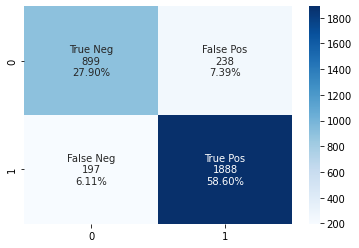

Accuracy: 0.8649906890130354
Precision: 0.8880526810912512
Recall: 0.9055155875299761


In [67]:
cm = confusion_matrix(y_test, model.predict(x_test))
plot_cm(cm)

## SVM + PCA

მესამე მეთოდი, რასაც შეიძლებოდა შედეგი გაეუმჯობესებინა, არის SVM-ის გამოყენებამდე Principal Component Analysis დეკომპოზიციის ჩატარება შემავალ მონაცემების სიმრავლეზე. ეს არის მეთოდი, რომლითაც შეგვიძლია შემავალი 385 Feature-დან მივიღოთ ნაკლები Feature ისე, რომ შევინარჩუნოთ რაც შეიძლება მეტი ინფორმაცია. ნაკლები ცვლადის მიღება ძირითადად იმიტომ გვსურს, რათა თავიდან ავირიდოთ ოვერფიტი, თუმცა ამასთან ერთად შეგვიძლია რიცხვობრივად შევაფასოთ თუ რომელი ცვლადი უფრო "მნიშვნელოვანია" საწყისი ცვლადებიდან.

In [68]:
from sklearn.decomposition import PCA

In [69]:
pca = PCA(n_components=385)
pca.fit(X, Y)
transformed = pca.transform(X)
transformed_40 = transformed[:, :40]

დავიყვანოთ ცვლადების რაოდენობა 40-ზე. დავხატოთ ე.წ. "Scree Plot" და ვნახოთ თუ დისპერსიის რა წილი უჭირავთ Principal Component-ებს. ეს რიცხვობრივად შეაფასებს თუ რამდენი ინფორმაცია გვეკარგება Feature-ების შემცირებით. კარგი შემთხვევა მაშინ არის, როცა პირველი რამდენიმე PC ბევრად მეტია დანარჩენზე.

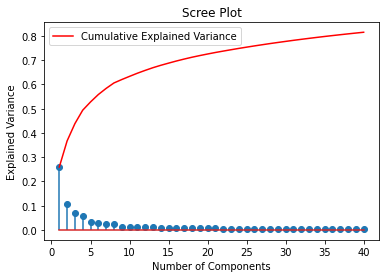

In [70]:
v = range(1, len(pca.explained_variance_ratio_[:40]) + 1)
plt.stem(v, pca.explained_variance_ratio_[:40])
plt.plot(v, np.cumsum(pca.explained_variance_ratio_[:40]), c='red', label='Cumulative Explained Variance')
plt.legend(loc='upper left')

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')
plt.show()

In [71]:
x_train, x_test, y_train, y_test = train_test_split(transformed_40, Y, test_size=0.3, random_state=42, stratify=Y)
model = LinearSVC(dual=False, random_state=42, penalty='l2', tol=1e-5)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.7588454376163873

როცა მონაცემები გარდავქმენით და მივიღეთ 40 ცვლადი, SVM-ის შედეგი 76%-მდე შემცრიდა. ეს პრინციპში მოსალოდნელი იყო, რადგან ოვერფიტი წინა შემთხვევაში არც გვქონია. კანონზომიერება ამ კონკრეტული მონაცემებისთვის არის ის რომ ცვლადების შემცირებით Accuracy მცირდება და გაზრდით იზრდება.

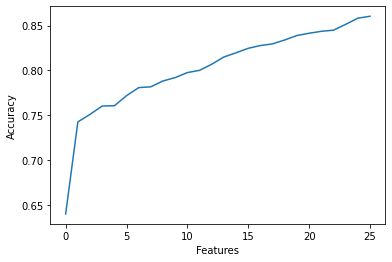

In [72]:
scores = []
x_tr, x_te, y_tr, y_te = train_test_split(transformed, Y, test_size=0.3, random_state=42, stratify=Y)
for i in range(0, 385, 15):
    m = LinearSVC(dual=False, random_state=42, penalty='l2', tol=1e-5)
    m.fit(x_tr[:, :(i + 1)], y_tr)
    scores.append(m.score(x_te[:, :(i + 1)], y_te))
plt.plot(scores)
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.show()

40 Feature-სთვის პერფორმანსის მეტრიკა ასე გამოიყურება:

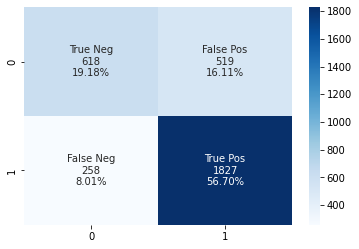

Accuracy: 0.7588454376163873
Precision: 0.7787723785166241
Recall: 0.8762589928057555


In [73]:
cm = confusion_matrix(y_test, model.predict(x_test))
plot_cm(cm)

In [74]:
# abs_components = np.sum(abs(pca.components_), axis=0)
# indices = abs_components.argsort()[-10:][::-1]

# print('Top 10 Features:')
# for i in indices:
#     weight = abs_components[i]
#     print(train.loc[:, train.columns != 'Alcoholic'].columns[i], weight)

## K-Nearest Neighbours

K-Nearest Neighbours (KNN) რეგრესიის და კლასიფიკაციის ალგორითმია, რომელიც სწორი კატეგორიის წინასწარმეტყველებას სატესტო მონაცემსა და ყველა სხვა მონაცემს შორის მანძილის გამოთვლით ცდილობს. ამ მეთოდზე ბევრს არ დავწერთ, რადგან მიუხედავად იმისა, რომ კლასიფიკატორისთვის ბევრი სხვადასხვა პარამეტრის გადაწოდება ვცადეთ, KNN მოდელმა არ იმუშავა.

In [75]:
from sklearn.neighbors import KNeighborsRegressor

In [76]:
X = train_norm.loc[:, train_norm.columns != 'Alcoholic'].to_numpy()
Y = train_norm['Alcoholic'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [77]:
model = KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='auto')
model.fit(x_train, y_train)

KNeighborsRegressor(weights='distance')

In [78]:
model.score(x_test, y_test)

0.44760752921269364

## Naive Bayes

Naive Bayes მანქანური სწავლების ალგორითმებიდან ერთ-ერთი ყველაზე მარტივი და ძლიერია კლასიფიკაციისთვის. ის ემყარება ბაიესის თეორემას იმ მკაცრი დაშვებით, რომ ცვლადები ერთმანეთისგან დამოუკიდებელია. მის სახელში "ნაივური" ზუსტად იმიტომ არის, რომ ცვლადების დამოუკიდებლობის დაშვება პრაქტიკაში ძალიან არარეალისტურია. თუმცა ამ კლასიფიკატორმა მაინც შეიძლება რომ კარგი შედეგები მოგვცეს.

In [79]:
from sklearn.naive_bayes import GaussianNB

In [80]:
model = GaussianNB()
model.fit(x_train, y_train)

GaussianNB()

In [81]:
model.score(x_test, y_test)

0.7135319677219119

ამ მეთოდით კლასიფიკაცია 71% სიზუსტეს გვაძლევს, რაც სხვა მეთოდებთან შედარებით ნაკლებია. 

In [82]:
model.score(x_train, y_train)

0.6976713240186294

ისე, ზოგადად, თუ Test და Train მონაცემების ქულას შევადარებთ შეგვიძლია მივხვდეთ გვაქვს თუ არა ოვერფიტისკენ მიდრეკილება. რადგან ეს ქულები ახლოს არიან, ამ შემთხვევაში ოვერფიტის პრობლემა არ გვაქვს.

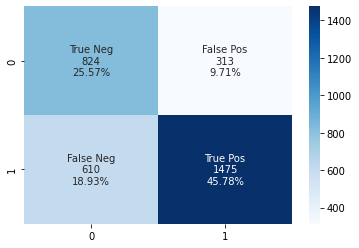

Accuracy: 0.7135319677219119
Precision: 0.8249440715883669
Recall: 0.7074340527577937


In [83]:
cm = confusion_matrix(y_test, model.predict(x_test))
plot_cm(cm)

In [84]:
auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
print(auc)

0.7786716273419259


# Conclusion

პროექტის მიმდინარეობისას სრულად გავიარეთ EEG მონაცემების დამუშავების ფუნდამენტური მეთოდები, განვიხილეთ მონაცემების გარდაქმნის მრავალი ფორმა და საბოლოოდ შევქმენით კლასიფიკაციის მოდელები. ამ ყველაფერს ახლავს შესაბამისი Python-ის კოდი და კომენტარები. ჩვენს მიერ შექმნილი მოდელებით და მათი პერფორმანსის ქულებით შეგვიძლია ავაგოთ ცხრილი, სადაც ყველა გამოყენებულ კლასიფიკაციის მეთოდს შევადარებთ.

|Method |Accuracy|Precision|Recall|AUC|
|-----|--------|---------|------|---|
|Logistic Regression|86.5%|88.4%|91.1%|92.7%|
|Support Vector Machines  |86.4%|88.8%|90.5%|-|
|SVM + PCA|75.8%|77.8%|87.6%|-|
|K-Nearest Neighbours|44%|-|-|-|
|Naive Bayes|68.6%|76.9%|73.5%|74.5%|

პროექტის მომავალი განვითარების პერსპექტივა არის Time-Series სიგნალების გარდაქმნის სხვა მეთოდების განხილვა, დამატებითი კლასიფიკატორების (განსაკუთრებით საინტერესოა ANN, CNN) და Dimensionality Reduction მეთოდების განხილვა, კროს-ვალიდაციის პრაქტიკა (რაც პროექტის ზომის გამო არ გამოვიყენეთ), მაგალითად GridSearchCV-ის გამოყენება, რომელიც ოპტიმალურ კლასიფიკატორის პარამეტრებს იპოვიდა, თუმცა დიდ კომპიუტერულ რესურსს მოითხოვს. ასევე, საინტერესო იქნებოდა EEG სიგნალების პრე-პროცესინგის სხვა მეთოდების, მაგალითად ხმაურის და სხვადასხვა არტიფაქტების გაფილტვრის, განხილვა.

# Literature:

https://www.youtube.com/watch?v=kuuUaqAjeoA

https://www.youtube.com/watch?v=fxfS0vSAsTA

https://www.frontiersin.org/articles/10.3389/fncom.2017.00103/full

https://www.sciencedirect.com/science/article/pii/S240584402101361X#br0290

https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

https://www.kaggle.com/code/ruslankl/eeg-data-analysis

https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1

https://www.youtube.com/watch?v=FgakZw6K1QQ

https://medium.com/swlh/k-nearest-neighbor-ca2593d7a3c4

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc